# Plots from GPT

> Python module to generate plot from json data and download an plotted image via OpenAI API.

In [ ]:
#| default_exp vision.plotting

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from llmcam.utils.file_manager import list_image_files, list_plot_files
from llmcam.vision.yolo import detect_objects
from llmcam.vision.gpt4v import ask_gpt4v_about_image_file

import os
import json
import matplotlib.pyplot as plt

## Generating plots from YOLO and GPT vision models

From the current modules in `vision`, we can retrieve information about an image. These information includes the counts of objects per class. Therefore, we can plot a bar chart for counts of objects of one class throughout the image list.

For this example, let us use captured images from Santa Claus Village to plot the number of people.

In [ ]:
#| eval: false
from pathlib import Path
import glob

data_path = Path(os.getenv("LLMCAM_DATA", "../data")).absolute()
files = sorted(glob.glob(f"{data_path}/cap_*.jpg"))
files = [ file for file in files if "santaclausvillage" in file ]
files = files[:2]

['/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_13:59:40_santaclausvillage.jpg',
 '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_14:02:23_santaclausvillage.jpg']

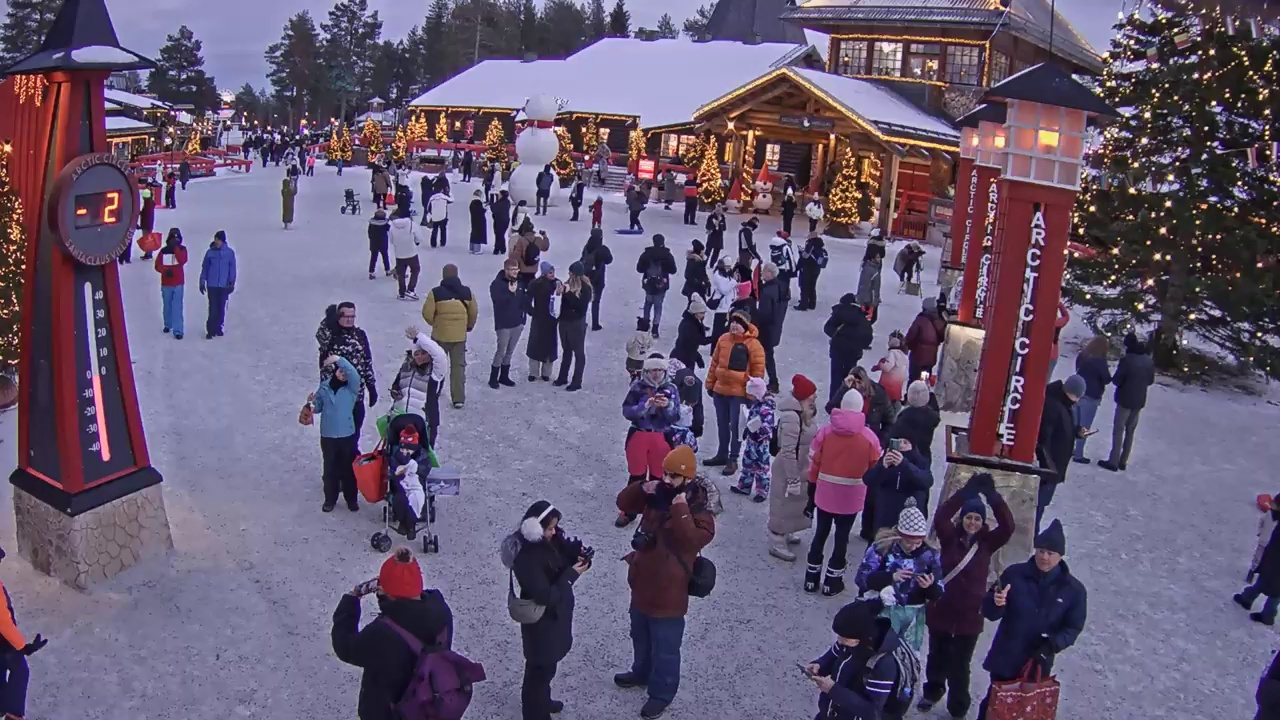

In [ ]:
#| eval: false
from IPython.display import display, Image
display(Image(files[0]))

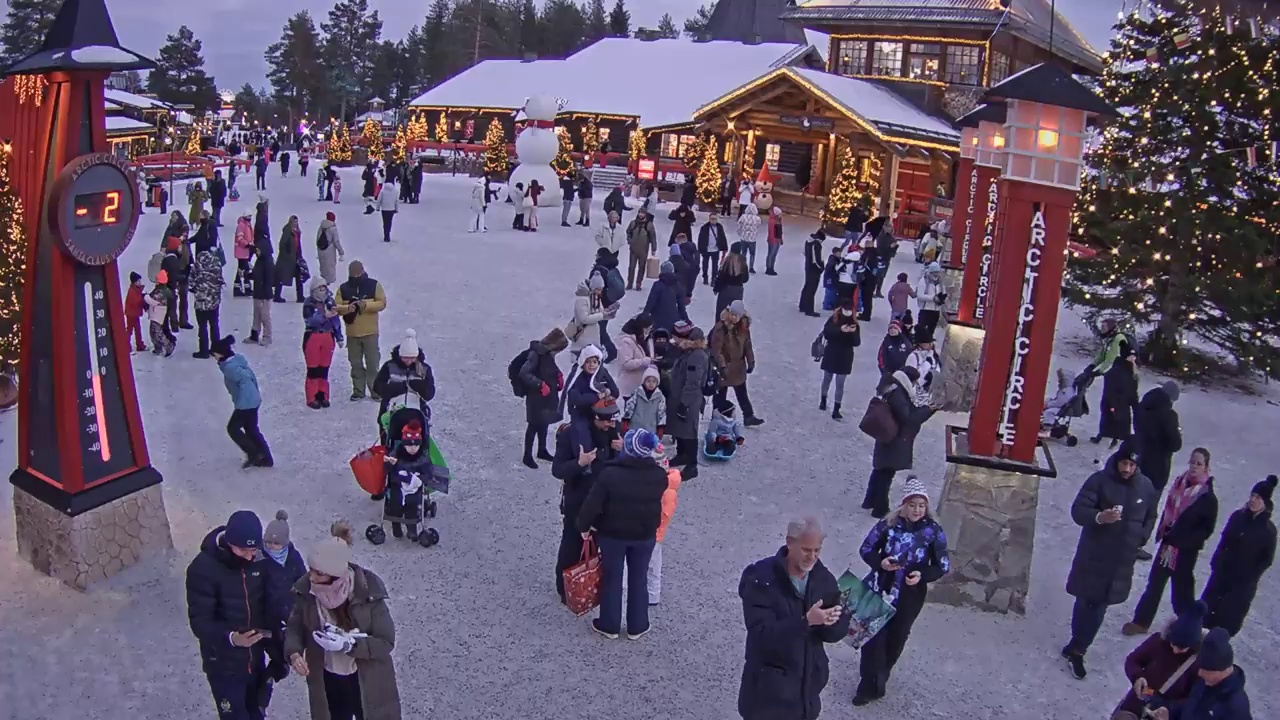

In [ ]:
#| eval: false
from IPython.display import display, Image
display(Image(files[1]))

In [ ]:
#| eval: false
# Define object to count
obj = "person"

### Plotting by GPT-4v

In [ ]:
#| eval: false
# Initiate counts per image
count = []

# Count objects in images
for image in files:
    info = ask_gpt4v_about_image_file(image)
    count.append(info.get(obj, 0))

count

[50, 40]

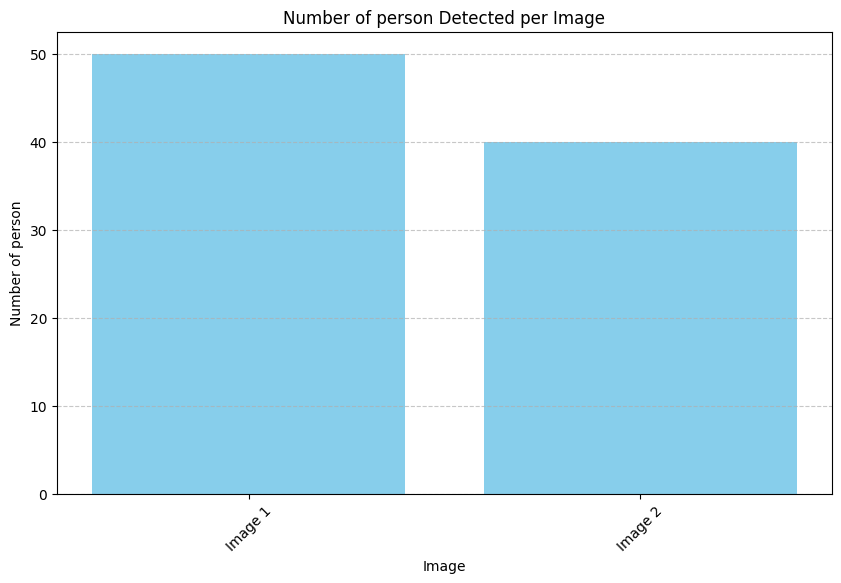

In [ ]:
#| eval: false
plt.figure(figsize=(10, 6))
plt.bar(files, count, color='skyblue')
plt.title(f'Number of {obj} Detected per Image')
plt.xlabel('Image')
plt.ylabel(f'Number of {obj}')
plt.xticks(range(len(files)), [f"Image {i+1}" for i in range(len(files))], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Plotting by YOLO 

In [ ]:
#| eval: false
# Initiate counts per image
count = []

# Count objects in images
for image in files:
    info = json.loads(detect_objects(image))
    count.append(info.get(obj, 0))

count


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_13:59:40_santaclausvillage.jpg: 384x640 21 persons, 2 handbags, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_14:02:23_santaclausvillage.jpg: 384x640 21 persons, 1 backpack, 3 handbags, 10.4ms
Speed: 1.5ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


[21, 21]

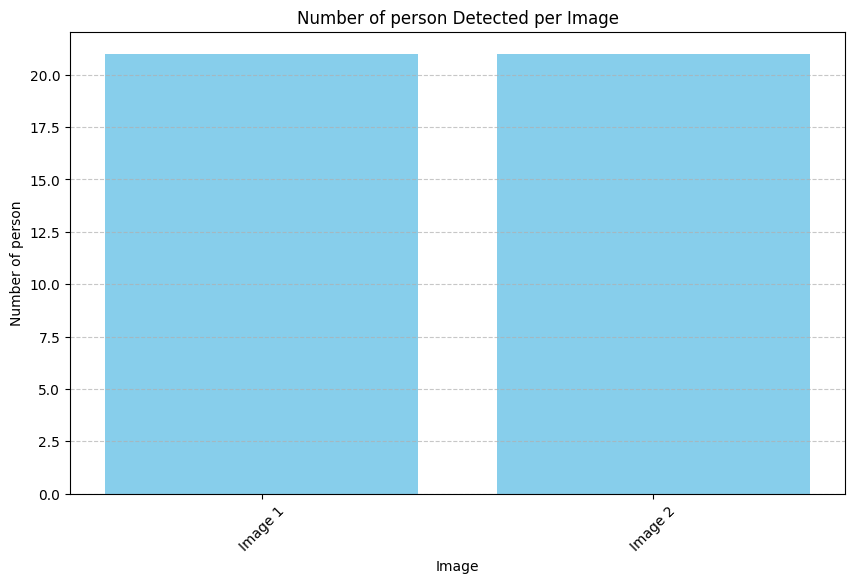

In [ ]:
#| eval: false
plt.figure(figsize=(10, 6))
plt.bar(files, count, color='skyblue')
plt.title(f'Number of {obj} Detected per Image')
plt.xlabel('Image')
plt.ylabel(f'Number of {obj}')
plt.xticks(range(len(files)), [f"Image {i+1}" for i in range(len(files))], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Combined and modularized function

We can combine these plots with `pyplot.subplots` and summarize this whole process into a single function to be integrated into our GPT Function calling framework:

In [ ]:
#| export
def plot_object(
    images: list[str],  # List of images to be extracted
    object: str,  # Object to detect
    methods: list[str] = ["gpt", "yolo"],  # List of methods to use for extracting information
):
    """
    Generate (only when requested) a bar plot displaying the number of instances of a specified object detected in a list of images, accepting only objects in singular form.
    Change the methods name to lowercase before passing to the function
    """
    # Determine local working directory and initiate path to save plot
    work_dir = os.getenv("LLMCAM_DATA", "../data")
    number = len(list_plot_files())
    path = os.path.join(work_dir, f"{number}_object_count_plot.jpg")

    # Determine which method to use
    yolo = any('yolo' in method.lower() for method in methods)
    gpt = any('gpt' in method.lower() for method in methods)

    # Initiate counts per image
    count_yolo = []
    count_gpt = []

    # Count objects in images
    if yolo:
        for image in images:
            image = work_dir + "/" + image.split("/")[-1]
            info = json.loads(detect_objects(image))
            count_yolo.append(info.get(object, 0))
    
    if gpt:
        for image in images:
            image = work_dir + "/" + image.split("/")[-1]
            info = ask_gpt4v_about_image_file(image)
            count_gpt.append(info.get(object, 0))

    # Plot the number of objects detected per image
    if yolo and gpt:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

        # YOLO plot
        axs[0].bar(images, count_yolo, color='skyblue')
        axs[0].set_title(f'YOLO: Number of {object} Detected')
        axs[0].set_ylabel(f'Number of {object}')
        axs[0].set_xlabel('Image')
        axs[0].set_xticks(range(len(images)))
        axs[0].set_xticklabels([f"Image {i+1}" for i in range(len(images))], rotation=45)
        axs[0].grid(axis='x', linestyle='--', alpha=0.7)

        # GPT-4 Vision plot
        axs[1].bar(images, count_gpt, color='lightcoral')
        axs[1].set_title(f'GPT: Number of {object} Detected')
        axs[0].set_xlabel('Image')
        axs[1].set_xticks(range(len(images)))
        axs[1].set_xticklabels([f"Image {i+1}" for i in range(len(images))], rotation=45)
        axs[1].grid(axis='x', linestyle='--', alpha=0.7)

        # Adjust layout
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

    elif yolo or gpt:
        count = count_yolo if yolo else count_gpt
        plt.figure(figsize=(10, 6))
        plt.bar(images, count, color='skyblue')
        plt.title(f'Number of {object} Detected per Image')
        plt.xlabel('Image')
        plt.ylabel(f'Number of {object}')
        plt.xticks(range(len(images)), [f"Image {i+1}" for i in range(len(images))], rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Save plot
        plt.savefig(path)
        plt.close()

    return json.dumps({"path": path})

In [ ]:
show_doc(plot_object)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/plotting.py#L17){target="_blank" style="float:right; font-size:smaller"}

### plot_object

>      plot_object (images:list[str], object:str, methods:list[str]=['gpt',
>                   'yolo'])

*Generate (only when requested) a bar plot displaying the number of instances of a specified object detected in a list of images, accepting only objects in singular form.
Change the methods name to lowercase before passing to the function*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| images | list |  | List of images to be extracted |
| object | str |  | Object to detect |
| methods | list | ['gpt', 'yolo'] | List of methods to use for extracting information |


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_13:59:40_santaclausvillage.jpg: 384x640 21 persons, 2 handbags, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_14:02:23_santaclausvillage.jpg: 384x640 21 persons, 1 backpack, 3 handbags, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


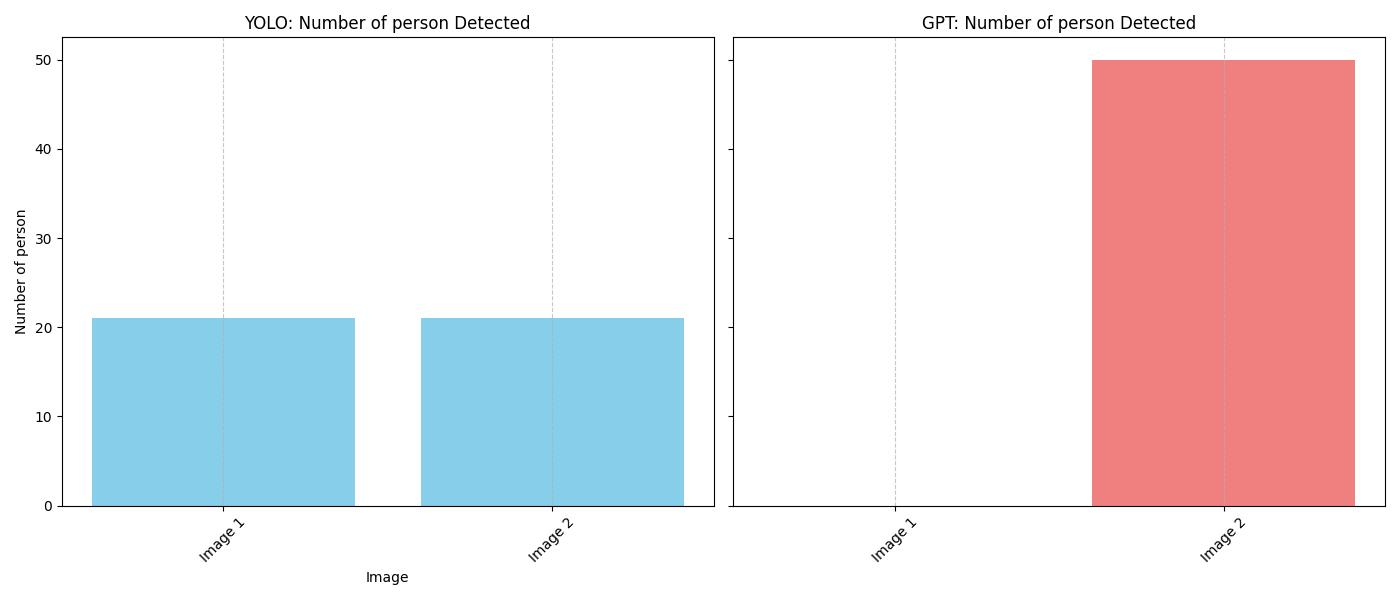

In [ ]:
#| eval: false
res = plot_object(files, "person", ["gpt", "yolo"])
path = json.loads(res).get("path")
display(Image(path))

## Simulated GPT framework

This section tests integrating with our current GPT framework. This function can be used in combination with previous functions in the `vision` module and `file_manager.list_image_files`:

In [ ]:
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema
from llmcam.utils.file_manager import list_image_files

tools = [
    function_schema(list_image_files, "Local files"),
    function_schema(plot_object, "Plot objects"),
]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "List local image files from Santa Claus Village.")
])
complete(messages, tools=tools)
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
List local image files from Santa Claus Village.
>> Assistant:
Here are the local image files from Santa Claus Village:  1.
**cap_2024.12.09_20:32:50_santaclausvillege.jpg** 2.
**cap_2024.12.11_13:59:40_santaclausvillage.jpg** 3.
**cap_2024.12.11_14:02:23_santaclausvillage.jpg**  If you would like to perform any actions on these
files, such as detecting objects, please let me know!


In [ ]:
#| eval: false
# Continue the conversation and plot using both methods
messages.append(form_msg("user", "Plot the number of people detected in the images using both YOLO and GPT-4 Vision. Tell me the path to the plot."))
complete(messages, tools=tools)
print_msgs(messages)


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_20:32:50_santaclausvillege.jpg: 384x640 9 persons, 1 potted plant, 31.7ms
Speed: 2.7ms preprocess, 31.7ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_13:59:40_santaclausvillage.jpg: 384x640 21 persons, 2 handbags, 34.0ms
Speed: 1.9ms preprocess, 34.0ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_14:02:23_santaclausvillage.jpg: 384x640 21 persons, 1 backpack, 3 handbags, 25.8ms
Speed: 2.4ms preprocess, 25.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
List local image files from Santa Claus Village.
>> Assistant:
Here are the local image files from Santa Claus Village:  1.
**cap_2024.12.09_20:32:50_santaclausvillege.jpg** 2.
**cap_2024.12.11_1

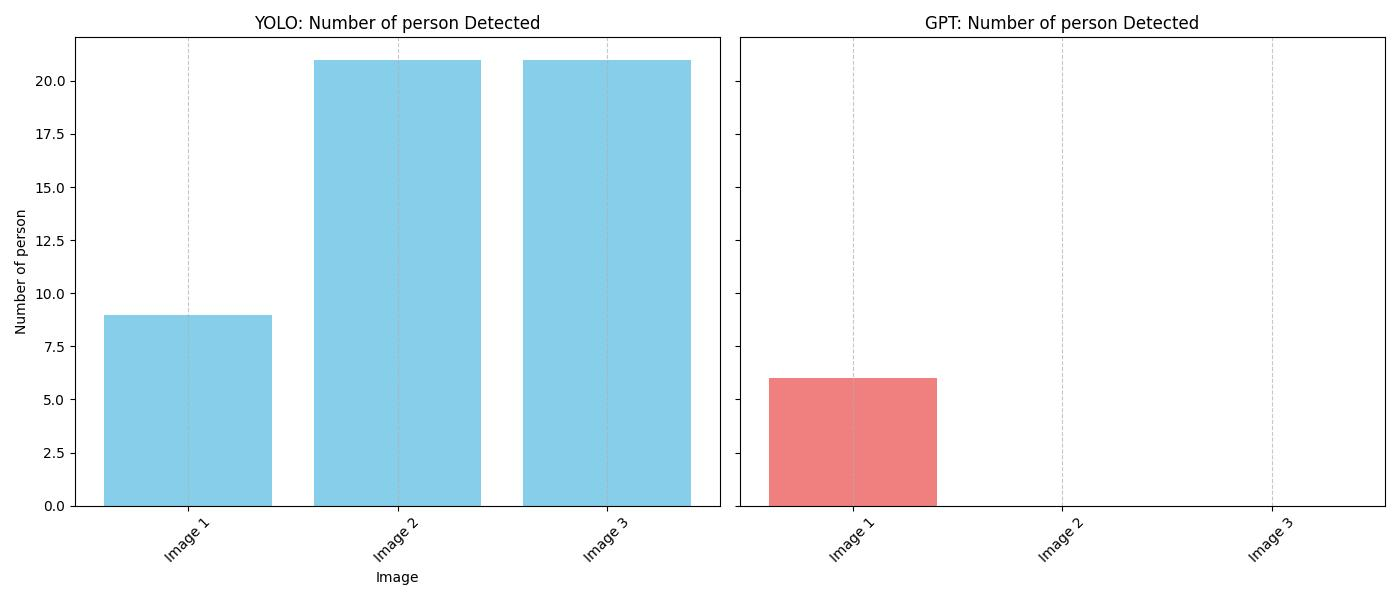

In [ ]:
#| eval: false
display(Image('/home/nghivo/tinyMLaaS/llmcam/data/118_object_count_plot.jpg'))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()